In [123]:
import tensorflow as tf
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.estimator import *
from tensorflow.keras.models import *
from tensorflow_core.python.keras.layers import CuDNNLSTM
from tensorflow_core.python.keras.layers.convolutional_recurrent import ConvLSTM2D
from tensorflow_core.python.keras.layers.normalization import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils.data_utils import Sequence
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
import pandas as pd
import glob
import pathlib
import math

In [124]:
df=pd.read_csv('C:/Users/hakim/PycharmProjects/kaggle-competition/data/train.csv') #training set list
columns=["healthy", "multiple_diseases", "rust", "scab"]
df_test=pd.read_csv('C:/Users/hakim/PycharmProjects/kaggle-competition/data/test.csv') #testing set list

#appending .jpg so that we can dirctly read the images from "image_id" column
df['image_id'] = df['image_id'].astype(str)+".jpg"
df_test['image_id'] = df_test['image_id'].astype(str)+".jpg"

In [100]:
#dfo = pd.read_csv('C:/Users/hakim/PycharmProjects/kaggle-competition/data/train.csv', delimiter=',')
#train_n = df['image_id'].value_counts()

In [125]:
BATCH_SIZE = 32
IMG_WIDGHT = 300
IMG_HEIGH = 300

#data augmentation
datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)

#training data 
train_generator=datagen.flow_from_dataframe(
    dataframe=df[:1460],
    directory='C:/Users/hakim/PycharmProjects/kaggle-competition/data/images',
    x_col="image_id",
    y_col=columns,
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(IMG_WIDGHT,IMG_HEIGH))


#validation data
valid_generator=test_datagen.flow_from_dataframe(
    dataframe=df[1460:],
    directory='C:/Users/hakim/PycharmProjects/kaggle-competition/data/images',
    x_col="image_id",
    y_col=columns,
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(IMG_WIDGHT,IMG_HEIGH))


#test data
test_generator=test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory='C:/Users/hakim/PycharmProjects/kaggle-competition/data/images',
    x_col="image_id",
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_WIDGHT,IMG_HEIGH))


Found 1460 validated image filenames.
Found 361 validated image filenames.
Found 1821 validated image filenames.


(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


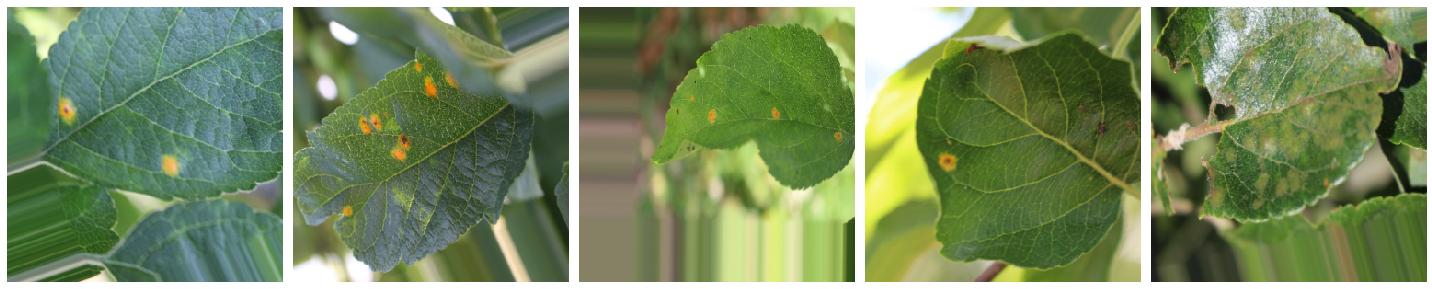

In [126]:
# plot some images
sample_training, _ = next(train_generator)

def plotImage(images):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        print(img.shape)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImage((sample_training[:5]))

In [132]:
def create_model():
    
    model = Sequential()

    model.add(Conv2D(16, (3, 3), padding='same',activation=relu, input_shape=(IMG_WIDGHT,IMG_HEIGH, 3)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3, 3),padding='same',activation=relu))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3),padding='same',activation=relu))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    
    model.add(Flatten())

    model.add(Dense(512, activation=relu))#, kernel_regularizer=l1_l2(l2=0.01) ))
    model.add(Dropout(0.2))

    model.add(Dense(4, activation=softmax))

    # compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=0.0001),
                  metrics=['accuracy'])
    return model


def create_model2():
    model = Sequential()

    model.add(Dense(512,activation=relu, input_shape=(IMG_WIDTH,IMG_HEIGHT, 3)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, activation=relu))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, activation=relu))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, activation=relu))
    model.add(Dropout(0.2))
    
    model.add(Flatten())

    model.add(Dense(512, activation=relu))#,  kernel_regularizer=l1_l2(l2=0.01) ))
    model.add(Dropout(0.2))

    model.add(Dense(4, activation=softmax))

    # compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    
    return model


def create_model3():
    #(32, 96)=(32,32,3)=>(150,450)
    m = Sequential()
    
    m.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                     input_shape=(None, IMG_WIDTH, IMG_HEIGHT, 3),
                     padding='same',
                     activation=relu,
                     return_sequences=True))
    m.add(BatchNormalization())
    
    m.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                     padding='same',
                     activation=relu,
                     return_sequences=True))
    m.add(BatchNormalization())
    
    m.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                     padding='same',
                     activation=relu,
                     return_sequences=False))
    m.add(BatchNormalization())
    
    m.add(Dense(512, activation=relu))
    m.add(Dropout(0.3))

    m.add(Dense(4, activation=softmax))

    m.compile(optimizer=Adam(),
                loss=categorical_crossentropy,
                metrics=['accuracy'])

    return m

In [133]:
# summary
model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 150, 150, 16)      0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 75, 75, 64)       

In [134]:
STEP_TRAIN=train_generator.n//train_generator.batch_size
STEP_VALID=valid_generator.n//valid_generator.batch_size
STEP_TEST=test_generator.n//test_generator.batch_size

print(STEP_TRAIN)
print(STEP_VALID)
print(STEP_TEST)

45
11
1821


In [135]:
history=model.fit_generator(generator=train_generator, 
                    steps_per_epoch=STEP_TRAIN, 
                    validation_data=valid_generator,
                    validation_steps=STEP_VALID,
                    epochs=200)

Epoch 1/150
45/45 [==============================] - 72s 2s/step - loss: 1.5941 - accuracy: 0.3417 - val_loss: 1.3200 - val_accuracy: 0.4261
Epoch 2/150
45/45 [==============================] - 72s 2s/step - loss: 1.2690 - accuracy: 0.3298 - val_loss: 1.3244 - val_accuracy: 0.4062
Epoch 3/150
45/45 [==============================] - 70s 2s/step - loss: 1.2357 - accuracy: 0.3599 - val_loss: 1.3352 - val_accuracy: 0.3949
Epoch 4/150
45/45 [==============================] - 69s 2s/step - loss: 1.2177 - accuracy: 0.3852 - val_loss: 1.3225 - val_accuracy: 0.4006
Epoch 5/150
45/45 [==============================] - 67s 1s/step - loss: 1.2182 - accuracy: 0.4027 - val_loss: 1.3017 - val_accuracy: 0.4659
Epoch 6/150
45/45 [==============================] - 67s 1s/step - loss: 1.2058 - accuracy: 0.4146 - val_loss: 1.2960 - val_accuracy: 0.4403
Epoch 7/150
45/45 [==============================] - 65s 1s/step - loss: 1.1958 - accuracy: 0.4322 - val_loss: 1.3088 - val_accuracy: 0.4773
Epoch 8/150
4

Epoch 59/150
45/45 [==============================] - 64s 1s/step - loss: 0.7355 - accuracy: 0.7227 - val_loss: 0.7066 - val_accuracy: 0.7528
Epoch 60/150
45/45 [==============================] - 63s 1s/step - loss: 0.7259 - accuracy: 0.7325 - val_loss: 0.7279 - val_accuracy: 0.7443
Epoch 61/150
45/45 [==============================] - 62s 1s/step - loss: 0.6888 - accuracy: 0.7577 - val_loss: 0.6870 - val_accuracy: 0.7500
Epoch 62/150
45/45 [==============================] - 63s 1s/step - loss: 0.7064 - accuracy: 0.7285 - val_loss: 0.6924 - val_accuracy: 0.7500
Epoch 63/150
45/45 [==============================] - 62s 1s/step - loss: 0.6865 - accuracy: 0.7444 - val_loss: 0.6944 - val_accuracy: 0.7528
Epoch 64/150
45/45 [==============================] - 63s 1s/step - loss: 0.7081 - accuracy: 0.7424 - val_loss: 0.6750 - val_accuracy: 0.7557
Epoch 65/150
45/45 [==============================] - 62s 1s/step - loss: 0.6873 - accuracy: 0.7500 - val_loss: 0.6588 - val_accuracy: 0.7642
Epoch 

45/45 [==============================] - 61s 1s/step - loss: 0.5751 - accuracy: 0.7832 - val_loss: 0.6757 - val_accuracy: 0.7784
Epoch 117/150
45/45 [==============================] - 62s 1s/step - loss: 0.5745 - accuracy: 0.7780 - val_loss: 0.7361 - val_accuracy: 0.7358
Epoch 118/150
45/45 [==============================] - 62s 1s/step - loss: 0.5711 - accuracy: 0.7836 - val_loss: 0.6684 - val_accuracy: 0.7784
Epoch 119/150
45/45 [==============================] - 63s 1s/step - loss: 0.5511 - accuracy: 0.7833 - val_loss: 0.6656 - val_accuracy: 0.7670
Epoch 120/150
45/45 [==============================] - 61s 1s/step - loss: 0.5489 - accuracy: 0.7945 - val_loss: 0.7260 - val_accuracy: 0.7528
Epoch 121/150
45/45 [==============================] - 62s 1s/step - loss: 0.5760 - accuracy: 0.7836 - val_loss: 0.6806 - val_accuracy: 0.7812
Epoch 122/150
45/45 [==============================] - 62s 1s/step - loss: 0.5279 - accuracy: 0.7910 - val_loss: 0.6672 - val_accuracy: 0.7756
Epoch 123/150

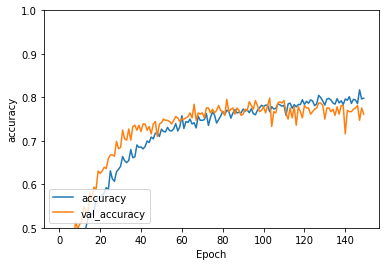

In [136]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower left')

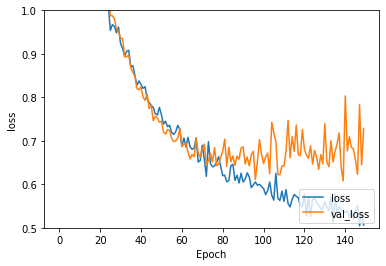

In [137]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [138]:
# evaluating the model
model.evaluate_generator(generator=valid_generator,
                         steps=STEP_VALID)

[0.7284224466844038, 0.7613636]

In [139]:
# predict the output
test_generator.reset()
pred = model.predict_generator(test_generator, steps=STEP_TEST, verbose=1,)

1821/1821 [==============================] - 57s 31ms/step


In [140]:
tmp_filenames = [id[0:10] for id in test_generator.filenames]
filenames=[]
for file in tmp_filenames:
    f = file.split('.')
    filenames.append(f[0])
    
df = pd.DataFrame({'image_id': filenames})
df = df.join(pd.DataFrame(data=pred, columns=columns))

In [141]:
df.head(10)

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,8.732805e-09,0.010413,0.989587,1.159235e-11
1,Test_1,2.922496e-07,0.021381,0.978618,1.346525e-09
2,Test_2,3.929255e-01,0.046449,0.038202,5.224233e-01
3,Test_3,8.671936e-01,0.012082,0.115576,5.148338e-03
4,Test_4,1.320966e-22,0.000030,0.999970,4.213589e-27
5,Test_5,8.639956e-01,0.022589,0.074667,3.874847e-02
6,Test_6,3.194255e-01,0.169031,0.401627,1.099163e-01
7,Test_7,1.712664e-01,0.213404,0.293960,3.213705e-01
8,Test_8,6.600621e-01,0.009537,0.229140,1.012610e-01
9,Test_9,1.373351e-06,0.015630,0.984369,2.094595e-08


In [142]:
df.to_csv("results.csv", index=False)